In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import maze
import renderer
import os.path
import numpy as np
import levels
import utils
import matplotlib.pyplot as plt

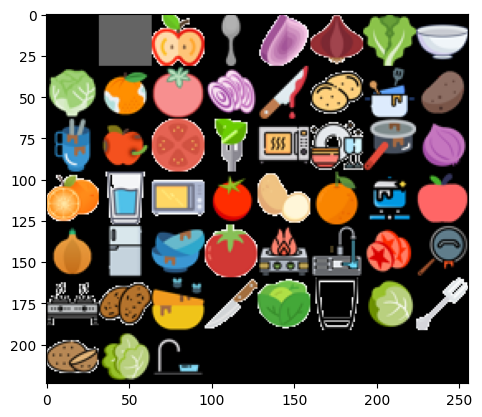

((224, 256, 3),
 ['empty', 'wall', 'apple_sliced', 'spoon', 'onion_sliced_cooked'])

In [11]:
# load images and display them
image_dict = renderer.load_image_dict('image_data.pkl')
image = renderer.create_image_grid_from_image_tensor(image_dict['images'], max_cols=8)
plt.imshow(image)
plt.show()
image.shape, image_dict['keys'][:5]

In [4]:
maze1 = """
.............
.............
.............
.............
...#######...
...#.....#...
...#..>..#...
...#.A...#...
...#...B.#...
...#######...
.............
.............
.............
""".strip()

maze2 = """
.#.C...##....
.#..D...####.
.######......
......######.
.#.#..#......
.#.#.##..#...
##.#.#>.###.#
A..#.##..#...
.B.#.........
#####.#..####
......####.#.
.######E.#.#.
........F#...
""".strip()


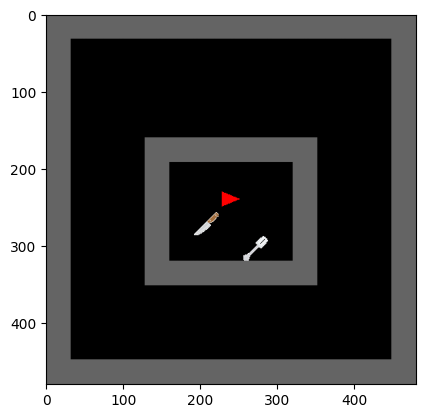

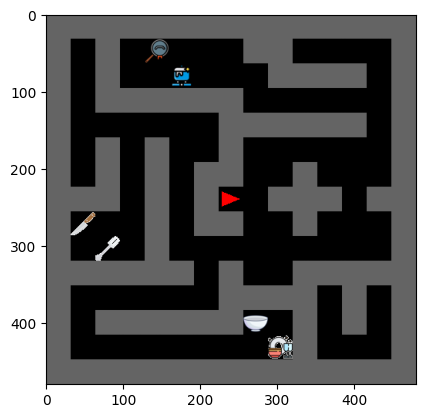

In [5]:
char_to_key=dict(
    A="knife",
    B="fork",
    C="pan",
    D="pot",
    E="bowl",
    F="plates",
)

object_to_index = {key: idx for idx, key in enumerate(image_dict['keys'])}

objects = np.array([object_to_index[v] for v in char_to_key.values()])

map1_init = utils.from_str(maze1, char_to_key=char_to_key, object_to_index=object_to_index)
image = renderer.create_image_from_grid(*map1_init, image_dict)
plt.imshow(image)
plt.show()

map2_init = utils.from_str(maze2, char_to_key=char_to_key, object_to_index=object_to_index)
image = renderer.create_image_from_grid(*map2_init, image_dict)
plt.imshow(image)
plt.show()


In [6]:
# combine both map inits into a single set of params for resetting

map_init = jtu.tree_map(lambda *v: jnp.stack(v), *(map1_init, map2_init))
map_init = maze.MapInit(*map_init)
jax.tree_map(lambda x: x.shape, map_init)


MapInit(grid=(2, 13, 13, 1), agent_pos=(2, 2), agent_dir=(2,))

In [7]:
# create env params
env_params = maze.EnvParams(
    map_init=jax.tree_map(jnp.asarray, map_init),
    time_limit=jnp.array(50),
    objects=jnp.asarray(objects))

In [8]:
# render fn
def render_timestep(timestep):
    image = renderer.create_image_from_grid(
        timestep.state.grid,
        timestep.state.agent_pos,
        timestep.state.agent_dir,
        image_dict)
    plt.imshow(image)
    plt.show()

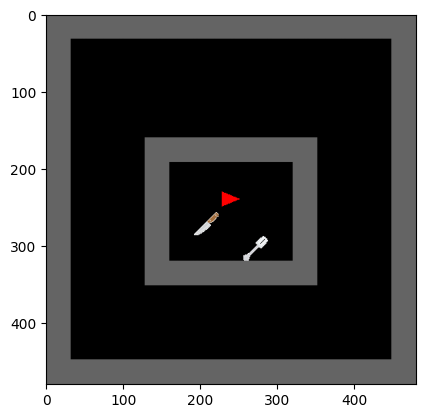

In [9]:
# initialize environment

seed = 6
rng = jax.random.PRNGKey(seed)

task_runner = maze.TaskRunner(task_objects=env_params.objects)
env = maze.HouseMaze(task_runner=task_runner)
env = utils.AutoResetWrapper(env)

reset_timestep = env.reset(rng, env_params)
render_timestep(reset_timestep)


reward: 0.0 | terminal: False


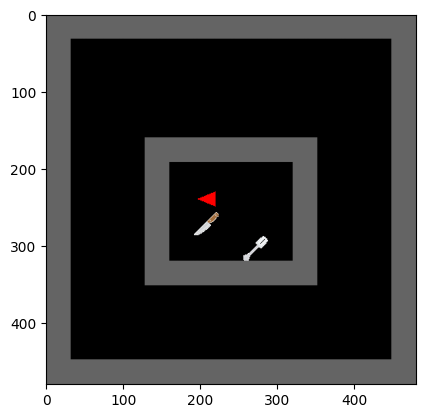

reward: 1.0 | terminal: True


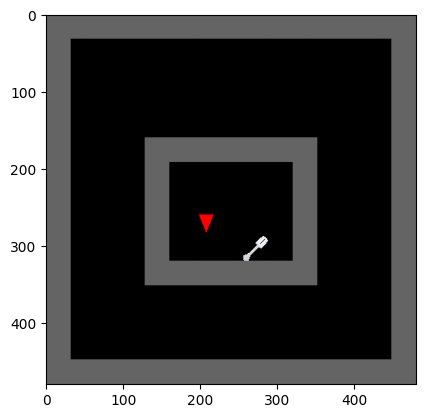

In [56]:
# test that
timestep = reset_timestep

for a in [
    maze.KeyboardActions.left,
    maze.KeyboardActions.down,
]:
    timestep = env.step(rng, timestep, a, env_params)
    print('reward:', timestep.reward, '| terminal:', timestep.last())
    render_timestep(timestep)
